# Summary #

<div class= 'alert alert-block alert-success'>
<b>The Titanic:</b>

The titanic sunk. Many died.\
Can we <b>predict those who survived</b>?

</div>

# Import packages, load data #

In [197]:
### IMPORT
### GENERAL PACKAGES
import numpy as np, pandas as pd, statsmodels.api as sm
import os

### SETUP
pd.set_option('display.max_columns', None)

### PLOTTING
import seaborn as sns, matplotlib.pyplot as plt

### DATA MANIPULATION
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD

### MODELS
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, GaussianNB, ComplementNB, BernoulliNB

### EXPORTING MODELS
import pickle

### VALIDATION
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

In [198]:
# LOOK FOR FILES
!ls /kaggle/input/titanic/

gender_submission.csv  test.csv  train.csv


In [199]:
# LOAD DATA
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

# Exploratory Data Analysis (EDA)

# Inspect data for completeness #

In [200]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [201]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [202]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<div class= 'alert alert-block alert-danger'>
<b>Missing train data:</b>

* 891 entries, with data types int64, float64, and string
* many entries missing from AGE and, especially, CABIN
</div>

In [203]:
# CHECKING FOR DUPLICATED VALUES
df_train.duplicated().sum()

0

In [204]:
# CHECK TEST DATA
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [205]:
df_test.duplicated().sum()

0

# Trying to figure out _why_ there is missing data

In [206]:
def count_records(featcounts:str, feat:str, norecord:bool):
    """
    Counts FEATCOUNTS occurrences of each category of SEX, PCLASS, EMBARKED, FAMILY=SIBSP+PARCH
    for cases where FEAT={AGE,CABIN} records are absent or not (NORECORD={TRUE, FALSE})
    """
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Sex'] == 'male')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Sex'] == 'female')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 1)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 2)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 3)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'S')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'C')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'Q')]))

In [207]:
# COUNTS OF NO AGE OR CABIN RECORD AT EACH PASSENGER CLASS, GENDER, PORT, FAMILY=SIBSP+PARCH
df_records = pd.DataFrame()
df_records['Feature'] = ['Gender(M)', 'Gender(F)', 'Class(1st)','Class(2nd)', 'Class(3rd)', 
                       'Port(Southampton)', 'Port(Cherbourg)', 'Port(Queenstown)']

counts_age = []; counts_noage = []; counts_cabin = []; counts_nocabin = []

count_records(counts_age, 'Age', False)
count_records(counts_noage, 'Age', True)
count_records(counts_cabin, 'Cabin', False)
count_records(counts_nocabin, 'Cabin', True)

df_records['Age_record'] = counts_age
df_records['No_age_record'] = counts_noage
df_records['Cabin_record'] = counts_cabin
df_records['No_cabin_record'] = counts_nocabin

print("""Number of passengers with/without AGE or CABIN records depending on GENDER, ticket CLASS,
port of EMBARKment:\n\n""", df_records)

Number of passengers with/without AGE or CABIN records depending on GENDER, ticket CLASS,
port of EMBARKment:

              Feature  Age_record  No_age_record  Cabin_record  No_cabin_record
0          Gender(M)         453            124           107              470
1          Gender(F)         261             53            97              217
2         Class(1st)         186             30           176               40
3         Class(2nd)         173             11            16              168
4         Class(3rd)         355            136            12              479
5  Port(Southampton)         554             90           129              515
6    Port(Cherbourg)         130             38            69               99
7   Port(Queenstown)          28             49             4               73


<div class="alert alert-block alert-info">
<b>Notes on data inspection:</b>

* TICKET data seems useless; some are strings with only numeric values, some are alphanumeric
* missing data could stem from port services, due to a much larger volume of inbound passengers:
    * about 70% of missing AGE/CABIN data related to 3rd class ticket passengers, with a similar percentage for male passengers
    * Southampton was the embarcation port for 72% of all passengers
</div>

<div class= 'alert alert-block alert-warning'>
<b>About train data completeness:</b>

* 891 entries, with data types int64, float64, and string
* 177 values missing from AGE field
* 687 values missing from CABIN field
* 2 values missing from EMBARK field
* no duplicate entries

<b>About test data completeness:</b>

* 418 entries, with data types int64, float64, and string
* test data also has missing values for AGE (327) and CABIN (86), and one missing entry for FARE
* no duplicate entries
</div>

## Univariate Distributions

In [208]:
# CREATE LIST OF FEATURES TO KEEP
select_features = []

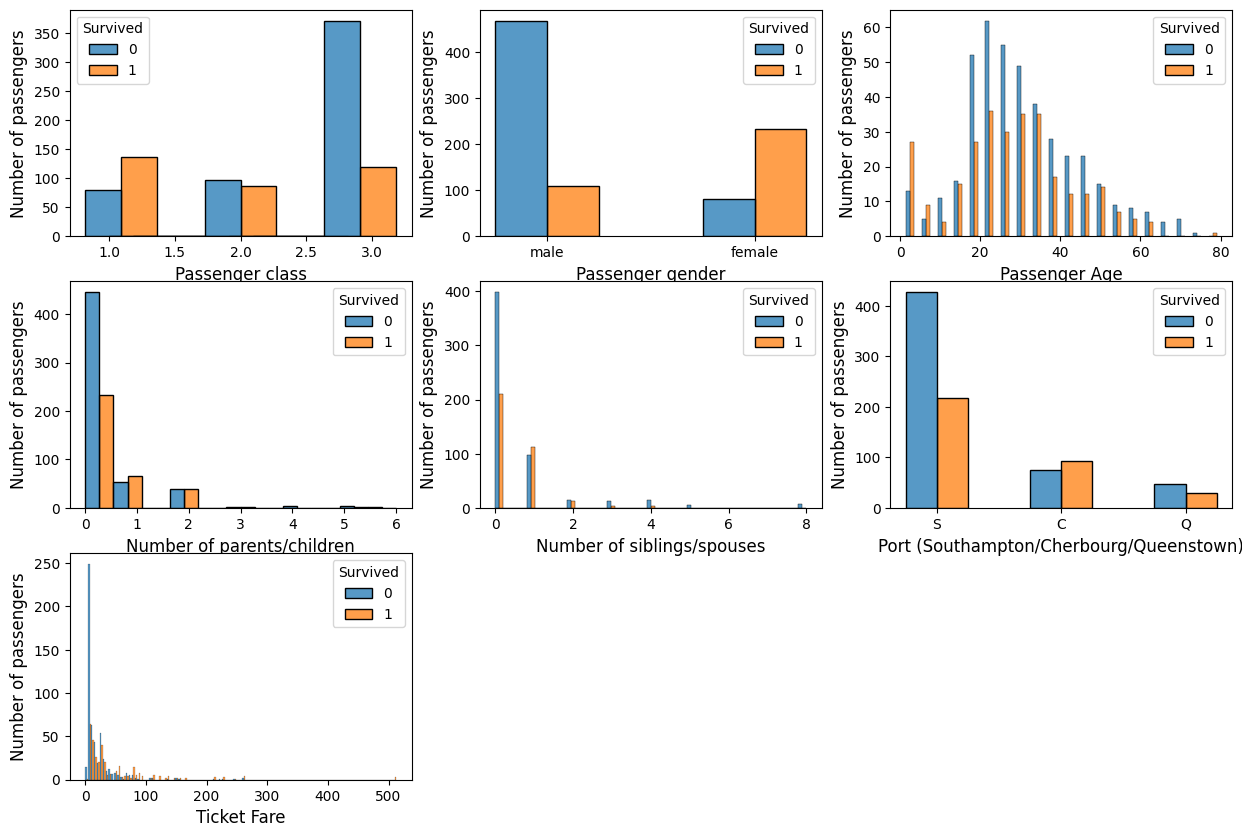

In [209]:
# ONE-DIMENSIONAL DISTRIBUTIONS
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (15,10))
gs = plt.GridSpec(3,3, height_ratios=(1,1,1))

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])
g6 = plt.subplot(gs[1, 2])
g7 = plt.subplot(gs[2, 0])


ax1 = sns.histplot(ax=g1, data = df_train, x='Pclass',hue = 'Survived', stat='count', multiple='dodge',shrink=3)
ax1.set_xlabel('Passenger class', fontsize=12)
ax1.set_ylabel('Number of passengers', fontsize=12)

ax2 = sns.histplot(ax=g2, data = df_train, x='Sex',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax2.set_xlabel('Passenger gender', fontsize=12)
ax2.set_ylabel('Number of passengers', fontsize=12)

ax3 = sns.histplot(ax=g3, data = df_train, x='Age',hue = 'Survived', stat='count', multiple='dodge',shrink=0.5)
ax3.set_xlabel('Passenger Age', fontsize=12)
ax3.set_ylabel('Number of passengers', fontsize=12)

ax4 = sns.histplot(ax=g4, data = df_train, x='Parch',hue = 'Survived', stat='count', multiple='dodge')
ax4.set_xlabel('Number of parents/children', fontsize=12)
ax4.set_ylabel('Number of passengers', fontsize=12)

ax5 = sns.histplot(ax=g5, data = df_train, x='SibSp',hue = 'Survived', stat='count', multiple='dodge')
ax5.set_xlabel('Number of siblings/spouses', fontsize=12)
ax5.set_ylabel('Number of passengers', fontsize=12)

ax6 = sns.histplot(ax=g6, data = df_train, x='Embarked',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax6.set_xlabel('Port (Southampton/Cherbourg/Queenstown)', fontsize=12)
ax6.set_ylabel('Number of passengers', fontsize=12)

ax7 = sns.histplot(ax=g7, data = df_train, x='Fare',hue = 'Survived', stat='count', multiple='dodge', shrink=1)
ax7.set_xlabel('Ticket Fare', fontsize=12)
ax7.set_ylabel('Number of passengers', fontsize=12)

fig.show()

In [210]:
select_features.append('Sex') ; select_features.append('Pclass')

<div class="alert alert-block alert-success">
<b>SEX, PCLASS, EMBARKED, SIBSP, PARCH:</b>

* These features seem to be promissing predictors;
* Sex, in particular, seems to have the most predictive power.
</div>

## Creating the FAMILY features ##

In [211]:
# FAMILY_BIN = PARCH + SIBSP >0 OR NOT
# DEFINE FUNCTION TO ASSIGN FAMILY VALUES BASED ON PARCH AND SIBSP
def fam(parch:int, sibsip:int):
    if (parch==0) & (sibsip==0):
        return 'no'
    else:
        return 'yes'
# APPLY FUNCTION
df_train['Family_yn'] = df_train.apply(lambda x: fam(x.Parch, x['SibSp']), axis=1)
df_test['Family_yn'] = df_test.apply(lambda x: fam(x.Parch, x['SibSp']), axis=1)
# FAMILY = PARCH + SIBSP
df_train['Family'] = df_train['SibSp'] + df_train['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']
# FAMILY SIZE, ACCORDING TO VARIATION IN SURVIVED FEATURE
def famsize(family):
    if family == 0:
        return 'alone'
    elif family < 4:
        return 'small'
    else:
        return 'large'
# APPLY FUNCTION; pd.Categorical SETS AN ORDINALITY TO THE CATEGORIES THAT WILL BE USED WHEN, E.G., PLOTTING
df_train['Famsize'] = pd.Categorical(df_train['Family'].apply(famsize), categories=['alone', 'small', 'large'])
df_test['Famsize'] = pd.Categorical(df_test['Family'].apply(famsize), categories=['alone', 'small', 'large'])

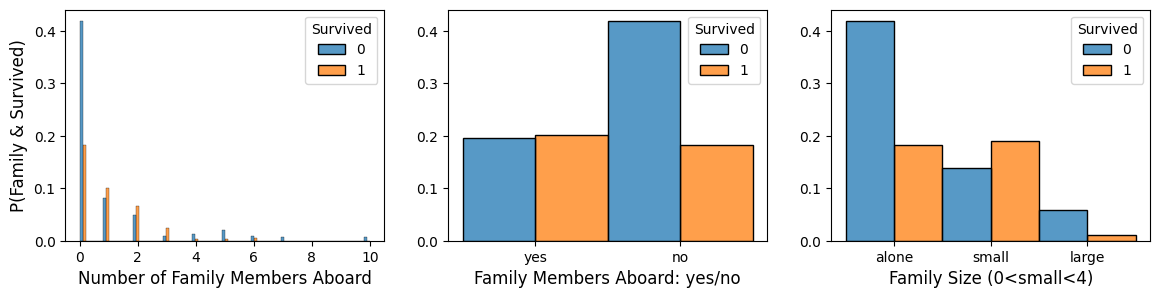

In [212]:
# PLOT FAMILY FEATURES
fig_fam = plt.figure(figsize = (14,3))
gs = plt.GridSpec(1,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
# PLOT FAMILY, FAMILY_YN, FAMSIZE
ax_list = ['ax1', 'ax2', 'ax3']
gpts_list = [g1, g2, g3]
feat_list = ['Family', 'Family_yn', 'Famsize']
xlbl_list = ['Number of Family Members Aboard', 'Family Members Aboard: yes/no', 'Family Size (0<small<4)']
ylbl_list = ['P(Family & Survived)', '', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
fig_fam.show()

In [213]:
# APPEND FEATURE
select_features.append('Famsize'); select_features.append('Family_yn')

<div class="alert alert-block alert-success">
<b>FAMSIZE feature:</b>

* Passengers who travel without family members or with large families (more than four family members in total) are much less likely to survive;
* Passengers travelling with up to three other family members (small families) are more likely to survive;
</div>

## Extracting Titles from the NAME feature ##

In [214]:
# WRITE A FUNCTION TO SPLIT THE NAME STRING AND EXTRACT THE TITLE
def detach(inp):
    return list(inp.split(','))[1].split()[0]

# APPLY FUNCTION TO NAME FEATURE
df_train['Title'] = df_train['Name'].apply(lambda x: detach(x))
df_test['Title'] = df_test['Name'].apply(lambda x: detach(x))
# THERE IS A TITLE SPELLED "THE", WHICH BELONGS TO A COUNTESS: INDEX 759
df_train.loc[759,'Title'] = 'Countess'
# GROUP TITLES IN DICTIONARY ACCORDING TO DISTRIBUTION VS SURVIVED
titlegroup = {}
titlegroup.update(dict.fromkeys(['Mr.', 'Miss.', 'Mrs.', 'Ms.'],'Common'))
titlegroup.update(dict.fromkeys(['Master.', 'Dr.', 'Rev.'],'Professional'))
titlegroup.update(dict.fromkeys(['Major.', 'Col.', 'Capt.'],'Military'))
titlegroup.update(dict.fromkeys(['Don.', 'Sir.', 'Lady.', 'Mlle.', 'Mme.','Jonkheer.', 'Countess'],'Wealth'))
titledictcommon = {}
titledictcommon.update(dict.fromkeys(['Mr.', 'Miss.', 'Mrs.', 'Ms.'],'yes'))
titledictcommon.update(dict.fromkeys(['Master.', 'Dr.', 'Rev.', 'Major.', 'Col.', 'Capt.', 'Don.', 'Sir.', 'Lady.', 'Mlle.', 'Mme.','Jonkheer.', 'Countess'],'no'))
# GROUP TITLES
df_train['Titlegroup'] = df_train['Title'].map(titlegroup)
df_test['Titlegroup'] = df_test['Title'].map(titlegroup)
# SIMPLIFY TITLES
df_train['Titlecommon'] = df_train['Title'].map(titledictcommon)
df_test['Titlecommon'] = df_test['Title'].map(titledictcommon)

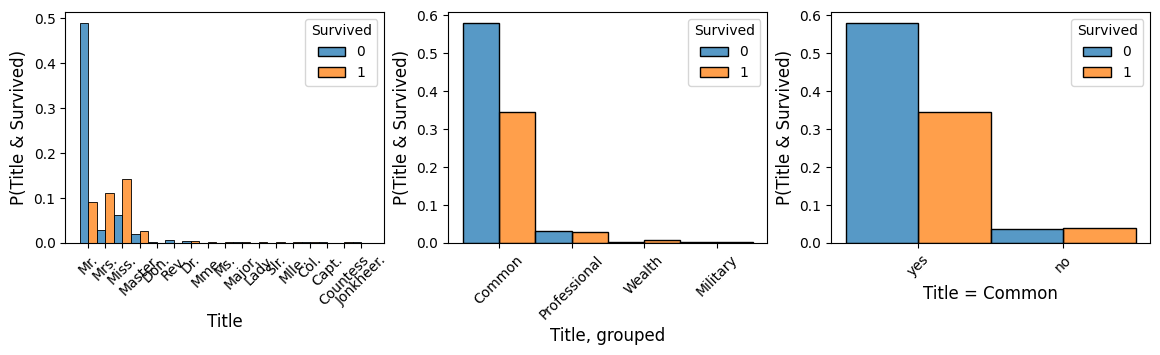

In [215]:
# PLOT TITLE FEATURES
fig_ttl = plt.figure(figsize = (14,3))
gs = plt.GridSpec(1,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
# PLOT TITLE, TITLEGROUP, TITLESIMPLE
ax_list = ['ax1', 'ax2', 'ax3']
gpts_list = [g1, g2, g3]
feat_list = ['Title', 'Titlegroup', 'Titlecommon']
xlbl_list = ['Title', 'Title, grouped', 'Title = Common']
ylbl_list = ['P(Title & Survived)', 'P(Title & Survived)', 'P(Title & Survived)']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
    axis.tick_params(axis='x', rotation = 45)
    fig_ttl.show()

In [216]:
# APPEND FEATURE
select_features.append('Titlecommon')

<div class="alert alert-block alert-success">
<b>TITLESIMPLE feature:</b>

* Passengers with TITLECOMMON=yes are less likely to survive;
* Passengers with TITLECOMMON=no are as likely to survive as not;
</div>

## Filling the FARE field in test data ##

In [217]:
# PASSENGERS WITHOUT FARE DATA IN TEST DATASET
df_test[df_test['Fare'].isna() == True]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_yn,Family,Famsize,Title,Titlegroup,Titlecommon
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,no,0,alone,Mr.,Common,yes


In [218]:
# CALCULATE MEDIAN OF FARE FOR RELEVANT PASSENGER FEATURES IN THE TRAIN DATASET AND ASSIGN IT
# 3rd PCLASS, MALE, NO FAMILY, SOUTHAMPTON
med_fare = df_train[(df_train['Pclass'] == 3) & (df_train['Sex'] == 'male') & (df_train['Family_yn'] == 'no') & (df_train['Embarked'] == 'S')]['Fare'].median()
df_test['Fare'] = df_test['Fare'].fillna(med_fare)

## Binning FARE into Quartiles ##

In [219]:
# BINNING FARE VALUES INTO QUARTILES
def quarts(fare):
    q1 = df_train['Fare'].quantile(0.25)
    q2 = df_train['Fare'].quantile(0.50)
    q3 = df_train['Fare'].quantile(0.75)
    if fare < q1:
        return 'Q1'
    elif fare < q2:
        return 'Q2'
    elif fare < q3:
        return 'Q3'
    elif fare >= q3:
        return 'Q4'

df_train['Fare_Q'] = pd.Categorical(df_train.apply(lambda x: quarts(x['Fare']), axis=1), categories = ['Q1', 'Q2', 'Q3', 'Q4'])
df_test['Fare_Q'] = pd.Categorical(df_test.apply(lambda x: quarts(x['Fare']), axis=1), categories = ['Q1', 'Q2', 'Q3', 'Q4'])
# BINNING FARE INTO Q4 OR NOT
def fareq4(fare):
    if fare == 'Q4':
        return 'yes'
    else:
        return 'no'
df_train['Fare_Q4'] = pd.Categorical(df_train.apply(lambda x: fareq4(x['Fare_Q']), axis=1), categories = ['no', 'yes'])
df_test['Fare_Q4'] = pd.Categorical(df_test.apply(lambda x: fareq4(x['Fare_Q']), axis=1), categories = ['no', 'yes'])

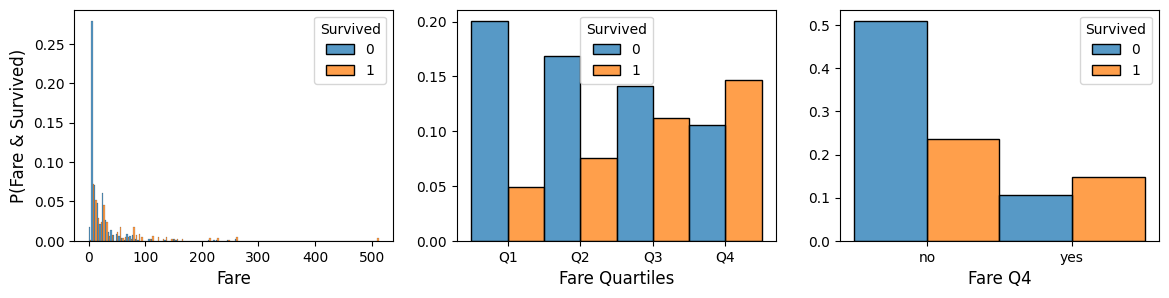

In [220]:
# PLOT FARE FEATURES
fig_fare = plt.figure(figsize = (14,3))
gs = plt.GridSpec(1,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
# PLOT FARE, FARE_Q, FARE_Q4
ax_list = ['ax1', 'ax2', 'ax3']
gpts_list = [g1, g2, g3]
feat_list = ['Fare', 'Fare_Q', 'Fare_Q4']
xlbl_list = ['Fare', 'Fare Quartiles', 'Fare Q4']
ylbl_list = ['P(Fare & Survived)', '', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
fig_fare.show()

In [221]:
# APPEND FEATURE
select_features.append('Fare_Q4')

<div class="alert alert-block alert-success">
<b>FARE_Q4 feature:</b>

* Passengers with FARE_Q4=no are less likely to survive;
* Passengers with FARE_Q4=yes are more likely to survive;
</div>

## Filling the EMBARKED field ##

In [222]:
# THE TWO MISSING EMBARKED VALUES IN THE TRAIN DATA ARE FOR FIRST CLASS FEMALES WITHOUT FAMILY ABOARD
# SHARING A CABIN, SO THE PORT COULD BE THE SAME
df_train[df_train['Embarked'].isna() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_yn,Family,Famsize,Title,Titlegroup,Titlecommon,Fare_Q,Fare_Q4
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,no,0,alone,Miss.,Common,yes,Q4,yes
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,no,0,alone,Mrs.,Common,yes,Q4,yes


In [223]:
# LOOKING AT RECORDS FROM FEMALES, WITHOUT FAMILY, FIRST CLASS
print(df_train[(df_train['Pclass'] == 1) & (df_train['Family_yn'] == 'no') & (df_train['Sex'] == 'female')].groupby('Embarked')['PassengerId'].count())
# OVER 50% PROBABILITY THAT BOTH CAME FROM CHERBOURG, SO WE'LL ASSIGN THAT AS EMBARKED PORT
df_train['Embarked'].fillna('C', inplace=True)

Embarked
C    18
S    14
Name: PassengerId, dtype: int64


In [224]:
# GROUPING EMBARKED INTO SOUTHAMPTON=Yes/No, ACCORDING TO DISTRIBUTION OF EMBARKED AND SURVIVED
def portsouth(port):
    if port == 'S':
        return 'yes'
    else:
        return 'no'
df_train['Port_SH'] = pd.Categorical(df_train['Embarked'].apply(portsouth), categories = ['no', 'yes'])
df_test['Port_SH'] = pd.Categorical(df_test['Embarked'].apply(portsouth), categories = ['no', 'yes'])

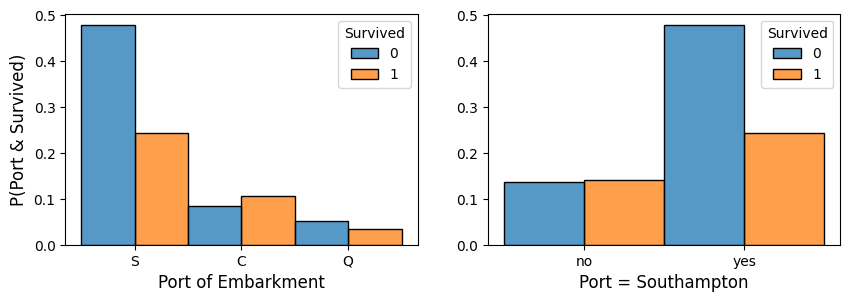

In [225]:
# PLOT EMBARKED FEATURES
fig_port = plt.figure(figsize = (10,3))
gs = plt.GridSpec(1,2)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
# PLOT EMBARKED, PORT_SH
ax_list = ['ax1', 'ax2']
gpts_list = [g1, g2]
feat_list = ['Embarked', 'Port_SH']
xlbl_list = ['Port of Embarkment', 'Port = Southampton']
ylbl_list = ['P(Port & Survived)', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
fig_port.show()

In [226]:
# APPEND FEATURE
select_features.append('Port_SH')

<div class="alert alert-block alert-success">
<b>PORT_SH feature:</b>

* Passengers embarking in Southampton are less likely to survive;
* Passengers embarking in other ports are as likely to survive as not;
</div>

## Creating the CabinId feature ##

In [227]:
# COUNTS OF CABIN IDENTIFIERS INCLUDING ONLY DIGITS (NOT LETTERS)
df_train['Cabin'].str.isnumeric().value_counts()

Cabin
False    204
Name: count, dtype: int64

In [228]:
# GET CABIN IDENTIFIER LETTER(S)
# THERE ARE TOO MANY CABINID CATEGORIES (EX: B, BB, BBB, BBBB), SO WE'LL KEEP ONLY THE FIRST LETTER
# THIS MEANS, FROM 1ST TO 3RD CLASS: T, A, B, C, D, E, F, G
def firstlet(cabin:str):
    if pd.isna(cabin)==False:
        return str(cabin)[0]
# APPLY FUNCITON
df_train['CabinId'] = pd.Categorical(df_train['Cabin'].apply(firstlet), categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
df_test['CabinId'] = pd.Categorical(df_test['Cabin'].apply(firstlet), categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])

In [229]:
df_train.groupby(['Pclass', 'CabinId']).PassengerId.count()

Pclass  CabinId
1       A          15
        B          47
        C          59
        D          29
        E          25
        F           0
        G           0
        T           1
2       A           0
        B           0
        C           0
        D           4
        E           4
        F           8
        G           0
        T           0
3       A           0
        B           0
        C           0
        D           0
        E           3
        F           5
        G           4
        T           0
Name: PassengerId, dtype: int64

<div class="alert alert-block alert-danger">
ENTRY 339 WAS PERMANENTLY DELETED!
</div>

In [230]:
# CBN_COMP=T IS A SINGLE ENTRY FOR THE CABIN, AND MAY RESULT IN PROBLEMS LATER ON
# WE WILL ELIMINATE THIS ENTRY PERMANENTLY (INDEX 339)
df_train = df_train.drop(index=339).reset_index(drop=True)

<div class="alert alert-block alert-danger">
ENTRY 339 WAS PERMANENTLY DELETED!
</div>

## Filling the CABINID field ##

In [231]:
# PEARSON CORRELATION BETWEEN CABINID AND OTHER FEATURES
corr = pd.get_dummies(df_train.drop(['PassengerId', 'Name', 'Ticket', 'Survived', 'Cabin'], axis=1)).corr()
# GET ROW AND COLUMN NUMBERS FOR -0.4 < PEARSON CORRELATION < 0.4 (USING ONLY LOWER HALF OF CORRELATION MATRIX)
row,col =  np.nonzero(abs(np.triu(corr.iloc[-7:,:-7]))>0.3)
# GET FEATURES NAME FROM COLUMN INDEXES
colname = []
for i,j in enumerate(corr.iloc[-8:,:-8].columns):
    if i in col:
        colname.append(j)
print(colname)

['Pclass', 'Fare', 'Fare_Q_Q4', 'Fare_Q4_no', 'Fare_Q4_yes']


In [232]:
# CREATE FUNCTION TO READ FEATURES WITH HIGHEST CORRELATION WITH CABINID (FARE AND FARE_Q4, THE OTHERS ARE REDUNDANT),
# FOR EACH CABINID=NaN ENTRY, EXTRACT ALL CABINID VALUES FOR SIMILAR FEATURES, 
# AND ASSIGN A RANDOMLY SAMPLED CABINRS VALUE
def sampler(fare:float, fare_q:str, cabinid:str):
    if pd.isnull(cabinid) == True:
        df = df_train[df_train['CabinId'].isna() == False]
        cbn_list = list(df[(df['Fare'] == fare) & (df['Fare_Q4'] == fare_q)]['CabinId'])
        if len(cbn_list) != 0:
            return np.random.choice(cbn_list)
        else:
            # MOST COMMON CABINID VALUE IS C
            return 'C'
    else:
        return cabinid
# RUN FUNCTION OVER CABINID
df_train['CabinRS'] = pd.Categorical(df_train.apply(lambda x: sampler(x['Fare'], x['Fare_Q4'], x['CabinId']), axis=1), categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'O'])
# FOR TEST DATA, USING THE SAME FUNCTION AS FOR THE TRAIN DATA
df_test['CabinRS'] = pd.Categorical(df_test.apply(lambda x: sampler(x['Fare'], x['Fare_Q4'], x['CabinId']), axis=1), categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'O'])

<div class="alert alert-block alert-info">
<b>Note on CABINID:</b>

* There are no features having a Pearson correlation coefficients larger than 0.4 with CABINID;
    * This was likely the cause of the failure in modeling CABINID with regressions, trees, and Naive Bayes (another notebook)
* The random sampling strategy will be tested, but likely abandoned;
* CABINID values will be imputed as the mode value of all entries.
</div>

In [233]:
# FINDING MOST COMMON CABINID VALUES
print(df_train['CabinId'].value_counts())
# FILL NaN VALUES IN CABINID WITH CABINID=C
df_train['CabinC'] = df_train['CabinId'].fillna('C')
df_test['CabinC'] = df_test['CabinId'].fillna('C')

CabinId
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     0
Name: count, dtype: int64


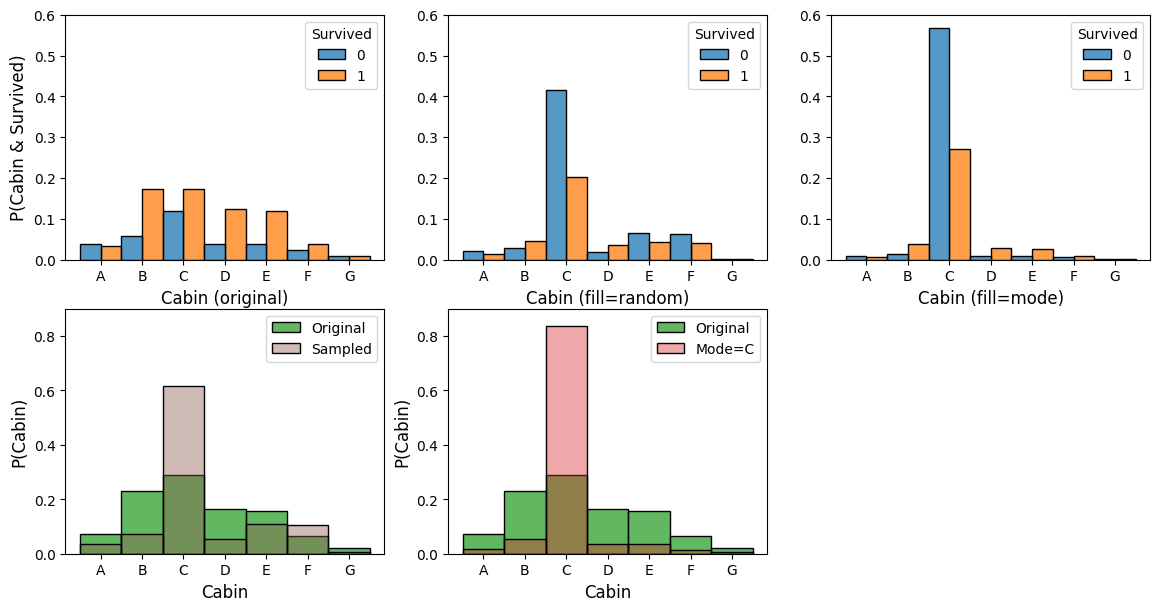

In [234]:
# PLOT CABINID FEATURES
fig_cbn = plt.figure(figsize = (14,7))
gs = plt.GridSpec(2,3, height_ratios=(1,1))
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])
# PLOT CABINID, CABINRS, CABINC
ax_list = ['ax1', 'ax2', 'ax3']
gpts_list = [g1, g2, g3]
feat_list = ['CabinId', 'CabinRS', 'CabinC']
xlbl_list = ['Cabin (original)', 'Cabin (fill=random)', 'Cabin (fill=mode)']
ylbl_list = ['P(Cabin & Survived)', '', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
    axis.set_ylim(0,0.6)
# PLOT COMPARISON OF ORIGINAL DISTRIBUTION AND DISTRIBUTIONS WITH ASSIGNED VALUES
ax4 = sns.histplot(ax=g4, data=df_train, x='CabinId', stat='probability', color='tab:green', label='Original')
ax4 = sns.histplot(ax=g4, data=df_train, x='CabinRS', stat='probability', color='tab:brown', label='Sampled', alpha=0.4)
ax4.legend()
ax4.set_xlabel('Cabin', fontsize=12)
ax4.set_ylabel('P(Cabin)', fontsize=12)
ax4.set_ylim(0,0.9)
ax5 = sns.histplot(ax=g5, data=df_train, x='CabinId', stat='probability', color='tab:green', label='Original')
ax5 = sns.histplot(ax=g5, data=df_train, x='CabinC', stat='probability', color='tab:red', label='Mode=C', alpha=0.4)
ax5.legend()
ax5.set_xlabel('Cabin', fontsize=12)
ax5.set_ylabel('P(Cabin)', fontsize=12)
ax5.set_ylim(0,0.9)
fig_cbn.show()

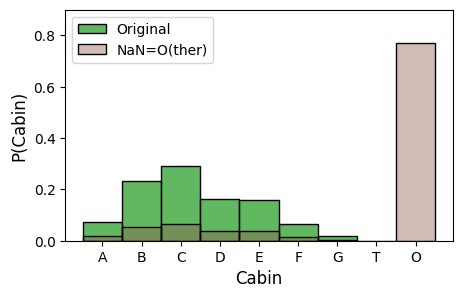

In [235]:
# ASSIGNING NaN VALUES IN CABIN ID TO THE CATEGORY O(THER)
df_train['CabinIdO'] = pd.Categorical(df_train['CabinId'], categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'O']).fillna('O')
df_test['CabinIdO'] = pd.Categorical(df_test['CabinId'], categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'O']).fillna('O')
# PLOT CABINID FEATURES
fig_cbno = plt.figure(figsize = (5,3))
# PLOT CABINID, CABINIDO
g=sns.histplot(data=df_train, x='CabinId', stat='probability', color='tab:green', label='Original')
g=sns.histplot(data=df_train, x='CabinIdO', stat='probability', color='tab:brown', label='NaN=O(ther)', alpha=0.4)
g.legend()
g.set_xlabel('Cabin', fontsize=12)
g.set_ylabel('P(Cabin)', fontsize=12)
g.set_ylim(0,0.9)
fig_cbno.show()
# APPEND FEATURE
select_features.append('CabinIdO')

<div class="alert alert-block alert-success">
<b>Note on CABINID AND CABINIDO:</b>

* Both assignment strategies decrease the original distributions' spread, heavily emphasising the occurrence of label C (as expected) while also reversing the probability ratio of surviving/not_surviving for cabin C;
    * this means the most populated CABINID feature now reports the opposite trend in survival probability;
* Missing CABINID entries will be assigned the value O(ther).
</div>

## Filling the AGE field ##

In [236]:
# PEARSON CORRELATION BETWEEN CABINID AND OTHER FEATURES
corr = pd.get_dummies(df_train.drop(['PassengerId', 'Name', 'Ticket', 'Survived', 'Cabin', 'CabinId', 'CabinRS', 'CabinC'], axis=1)).corr()
# SORTED CORRELATION VALUES
print('Ten highest correlated features with age:\n', pd.concat([corr.iloc[1,:].sort_values().head(5), corr.iloc[1,:].sort_values().tail(5)]))
# KEEP TITLE, PCLASS, SIBSP, FAMILY
# FOR EACH AGE=NaN ENTRY, EXTRACT ALL AGE VALUES FOR SIMILAR FEATURES, AND ASSIGN A RANDOMLY SAMPLED AGE VALUE
def sampler(pclass:int, family:str, sibsp:str, title:str, age:int):
    if pd.isnull(age) == True:
        df = df_train[df_train['Age'].isna() == False]
        age_list = list(df[(df['Pclass'] == pclass) & (df['Family'] == family) & (df['SibSp'] == sibsp) & (df['Title'] == title)]['Age'])
        if len(age_list) != 0:
            return np.random.choice(age_list)
        else:
            # MOST COMMON AGE VALUE IS 22.0
            return 22.0
    else:
        return age
# RUN FUNCTION OVER AGE
df_train['AgeRS'] = df_train.apply(lambda x: sampler(x['Pclass'], x['Family'], x['SibSp'], x['Title'], x['Age']), axis=1)
# FOR TEST DATA, USING THE SAME FUNCTION AS FOR THE TRAIN DATA
df_test['AgeRS'] = df_test.apply(lambda x: sampler(x['Pclass'], x['Family'], x['SibSp'], x['Title'], x['Age']), axis=1)

# FILL NaN VALUES IN AGE WITH MEDIAN AGE VALUE
agemed = df_train['Age'].quantile(0.5)
df_train['Agemed'] = df_train['Age'].fillna(agemed)
df_test['Agemed'] = df_test['Age'].fillna(agemed)

Ten highest correlated features with age:
 Title_Master.             -0.398812
Pclass                    -0.367893
SibSp                     -0.307737
Family                    -0.301293
Titlegroup_Professional   -0.288766
Family_yn_no               0.197235
Titlecommon_yes            0.197484
Titlegroup_Common          0.197484
Title_Mr.                  0.205298
Age                        1.000000
Name: Age, dtype: float64


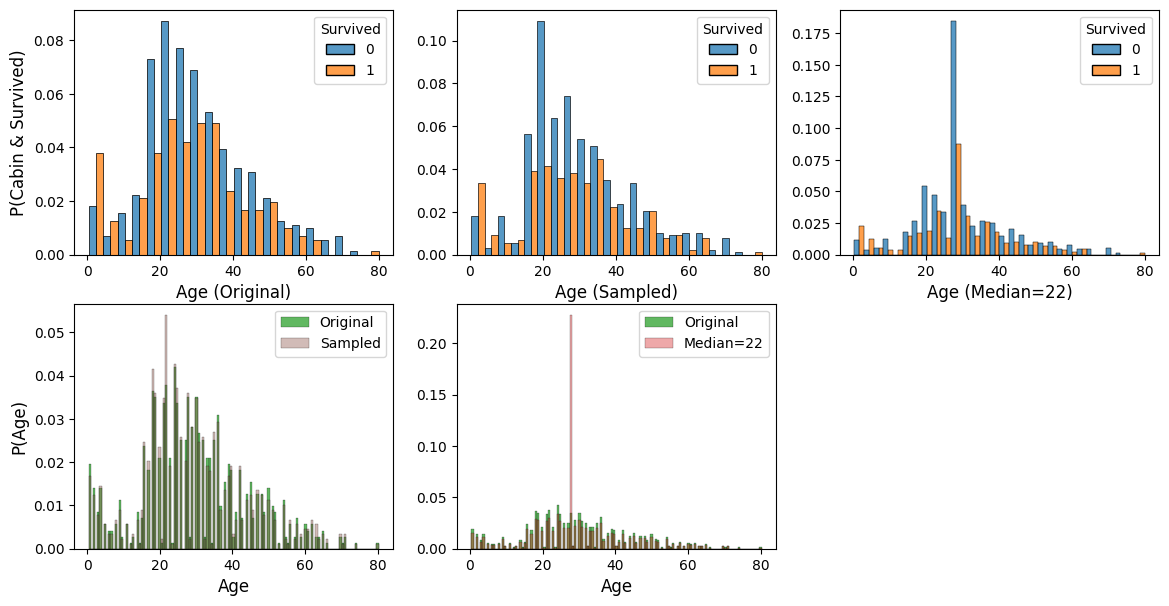

In [237]:
# PLOT AGE FEATURES
fig_age = plt.figure(figsize = (14,7))
gs = plt.GridSpec(2,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])
# PLOT AGE, AGERD, AGEMED
ax_list = ['ax1', 'ax2', 'ax3']
gpts_list = [g1, g2, g3]
feat_list = ['Age', 'AgeRS', 'Agemed']
xlbl_list = ['Age (Original)', 'Age (Sampled)', 'Age (Median=22)']
ylbl_list = ['P(Cabin & Survived)', '', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
# PLOT COMPARISON OF ORIGINAL DISTRIBUTION AND DISTRIBUTIONS WITH ASSIGNED VALUES
ax4 = sns.histplot(ax=g4, data=df_train, x='Age', stat='probability', color='tab:green', label='Original', binwidth=0.6)
ax4 = sns.histplot(ax=g4, data=df_train, x='AgeRS', stat='probability', color='tab:brown', label='Sampled', binwidth=0.6, alpha=0.4)
ax4.legend()
ax4.set_xlabel('Age', fontsize=12)
ax4.set_ylabel('P(Age)', fontsize=12)
ax5 = sns.histplot(ax=g5, data=df_train, x='Age', stat='probability', color='tab:green', label='Original', binwidth=0.6)
ax5 = sns.histplot(ax=g5, data=df_train, x='Agemed', stat='probability', color='tab:red', label='Median=22', binwidth=0.6, alpha=0.4)
ax5.legend()
ax5.set_xlabel('Age', fontsize=12)
ax5.set_ylabel('', fontsize=12)
fig_age.show()

In [238]:
# CREATE THE CHILD FEATURE ACCORDING TO AGE DISTRIBUTION FOR SURVIVED=YES
def child(age):
    if age<=5:
        return 'yes'
    else:
        return 'no'
df_train['Child'] = df_train['AgeRS'].apply(child)
df_test['Child'] = df_test['AgeRS'].apply(child)

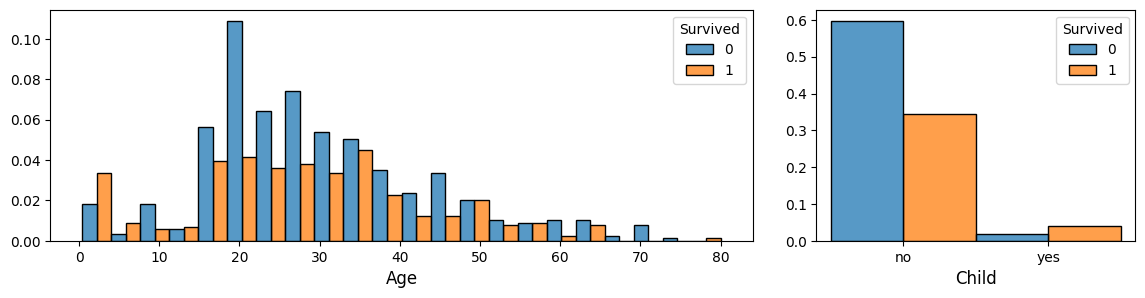

In [239]:
# PLOT AGE FEATURES
fig_age = plt.figure(figsize = (14,3))
gs = plt.GridSpec(1,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0:2])
g2 = plt.subplot(gs[0, 2])
# PLOT AGERS
ax1 = sns.histplot(ax=g1, data=df_train, x='AgeRS', stat='probability', hue='Survived', multiple='dodge')
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('', fontsize=12)
ax2 = sns.histplot(ax=g2, data=df_train, x='Child', stat='probability', hue='Survived', multiple='dodge')
ax2.set_xlabel('Child', fontsize=12)
ax2.set_ylabel('', fontsize=12)
fig_age.show()

In [240]:
# APPEND FEATURE
select_features.append('AgeRS'), select_features.append('Child')

(None, None)

<div class="alert alert-block alert-success">
<b>AGE_RS feature:</b>

* AGE_RS seems to mimick the original AGE distribution quite well;
* Children under 5 have a higher probability to survive.
</div>

<div class="alert alert-block alert-info">
<b>About lack of AGE and CABIN records:</b>

* AGE/CABIN records, both missing and existing, follow SEX, PCLASS, EMBARK, PARCH+SIBSP records
    * this is related to the large proportion of SEX=male, PCLASS=3, EMBARK=S, and PARCH+SIBSP=0
* there are sufficient AGE data that missing AGE records can be estimated
    * regression model
    * random sampling from distribution
    * NaiveBayes
    * ultimately, modeling didn't work well - the predictions were poor, so we went with random sampling instead
* for CABIN data, there are many more missing data points
    * all CABIN data start with one or more alphabet characters, from which CABINID was built
    * CABINID varies the most with PCLASS
    * CABINID could be estimated
        * also, modeling didn't work well here
        * no type of assignment worked - we're dropping CABIN information
</div>

## Bivariate distributions

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


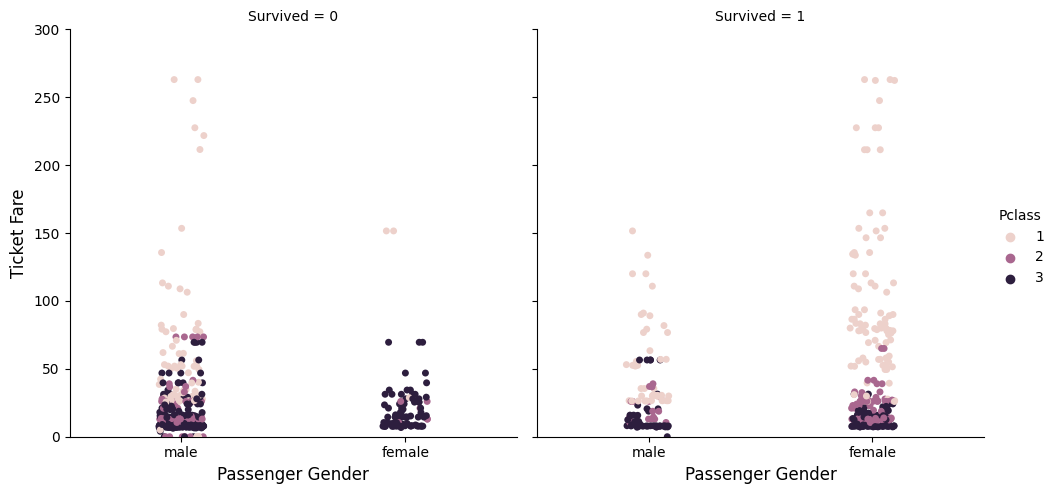

In [241]:
# NUMBER OF FAMILY MEMBERS ABOARD VS GENDER
g = sns.catplot(data = df_train, x='Sex',y='Fare', hue = 'Pclass', col='Survived')
for ax in g.axes.flat:
    ax.set_xlabel('Passenger Gender', fontsize=12)
    ax.set_ylabel('Ticket Fare', fontsize=12)
    ax.set_ylim(0,300)

In [242]:
# CREATE BINARY FEATURE FOR FEMALES IN THE FIRST CLASS
def femup(sex, pclass):
    if (sex == 'female') & (pclass == 1):
        return 'yes'
    else:
        return 'no'
df_train['Fem_first'] = df_train.apply(lambda x: femup(x['Sex'], x['Pclass']), axis=1)
df_test['Fem_first'] = df_test.apply(lambda x: femup(x['Sex'], x['Pclass']), axis=1)
# APPEND FEATURE
select_features.append('Fem_first')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


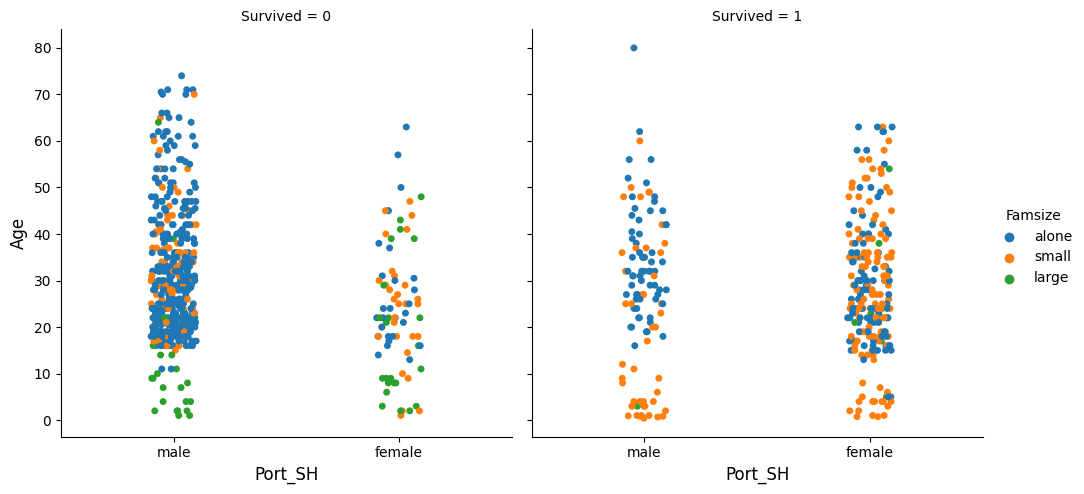

In [243]:
# TWO-DIMENSIONAL DISTRIBUTIONS
g = sns.catplot(data = df_train, x='Sex',y='AgeRS', hue = 'Famsize', col='Survived')
for ax in g.axes.flat:
    ax.set_xlabel('Port_SH', fontsize=12)
    ax.set_ylabel('Age', fontsize=12)

In [244]:
# CREATE BINARY FEATURE FOR MALES WITHOUT FAMILY MEMBERS
def manalone(sex, fam):
    if (sex == 'male') & (fam == 'no'):
        return 'yes'
    else:
        return 'no'
df_train['Manalone'] = df_train.apply(lambda x: manalone(x['Sex'], x['Family_yn']), axis=1)
df_test['Manalone'] = df_test.apply(lambda x: manalone(x['Sex'], x['Family_yn']), axis=1)
# APPEND FEATURE
select_features.append('Manalone')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


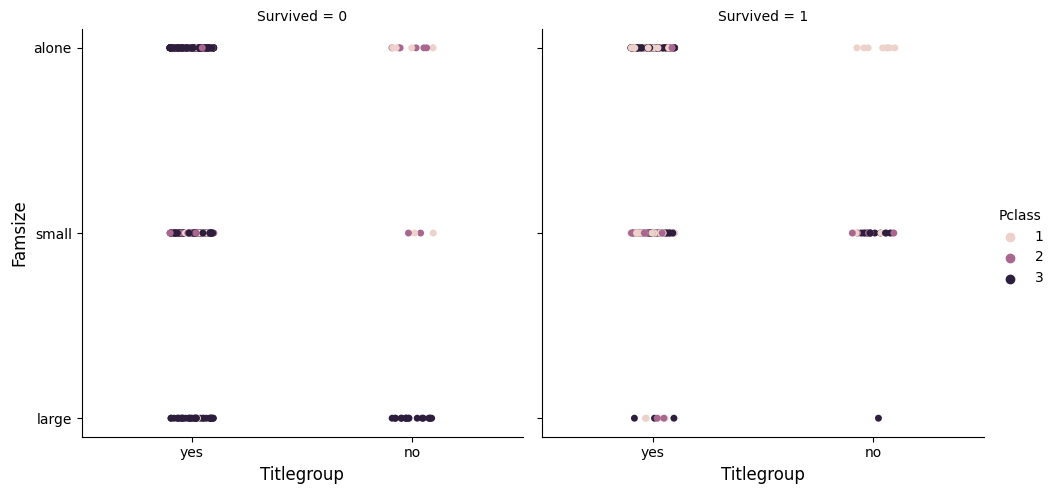

In [245]:
# TWO-DIMENSIONAL DISTRIBUTIONS
g = sns.catplot(data = df_train, x='Titlecommon',y='Famsize', hue = 'Pclass', col='Survived')
for ax in g.axes.flat:
    ax.set_xlabel('Titlegroup', fontsize=12)
    ax.set_ylabel('Famsize', fontsize=12)
    #ax.set_ylim(0,15)

In [246]:
# CREATE BINARY FEATURE FOR COMMON-TITLED PASSENGERS IN FIRST AND SECOND CLASSES
def commonup(title, pclass):
    if (title=='yes') & (pclass != 3):
        return 'yes'
    else:
        return 'no'
df_train['Common_upper'] = df_train.apply(lambda x: commonup(x['Titlecommon'], x['Pclass']), axis=1)
df_test['Common_upper'] = df_test.apply(lambda x: commonup(x['Titlecommon'], x['Pclass']), axis=1)
# APPEND FEATURE
select_features.append('Common_upper')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


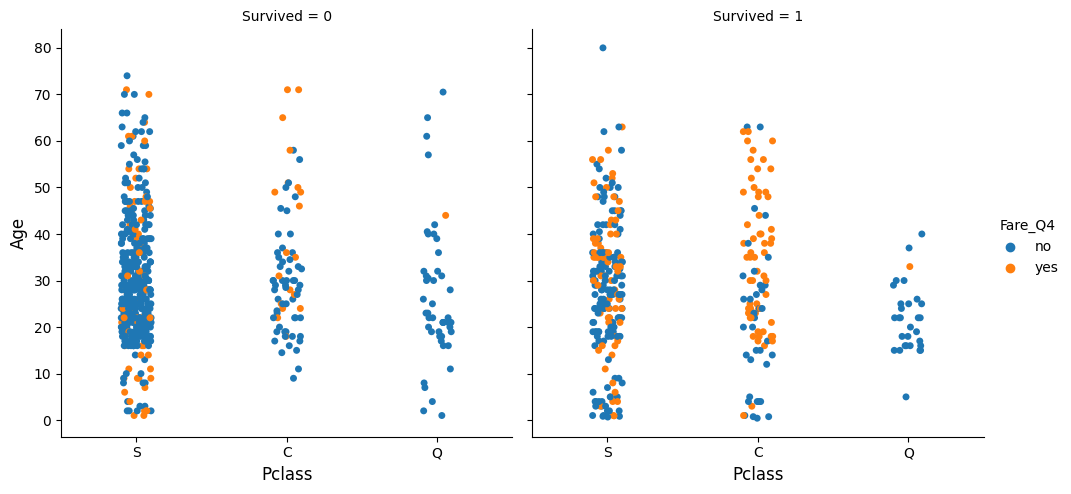

In [247]:
# TWO-DIMENSIONAL DISTRIBUTIONS
g = sns.catplot(data = df_train, x='Embarked',y='AgeRS', hue = 'Fare_Q4', col='Survived')
for ax in g.axes.flat:
    ax.set_xlabel('Pclass', fontsize=12)
    ax.set_ylabel('Age', fontsize=12)
    #ax.set_ylim(0,300)

In [248]:
# CREATE BINARY FEATURE FOR PASSENGERS IN FARE_Q4 EMBARKED IN CHERBOURG
def cherrich(fare, port):
    if (fare=='yes') & (port == 'C'):
        return 'yes'
    else:
        return 'no'
df_train['Cher_rich'] = df_train.apply(lambda x: cherrich(x['Fare_Q4'], x['Embarked']), axis=1)
df_test['Cher_rich'] = df_test.apply(lambda x: cherrich(x['Fare_Q4'], x['Embarked']), axis=1)
# APPEND FEATURE
select_features.append('Cher_rich')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


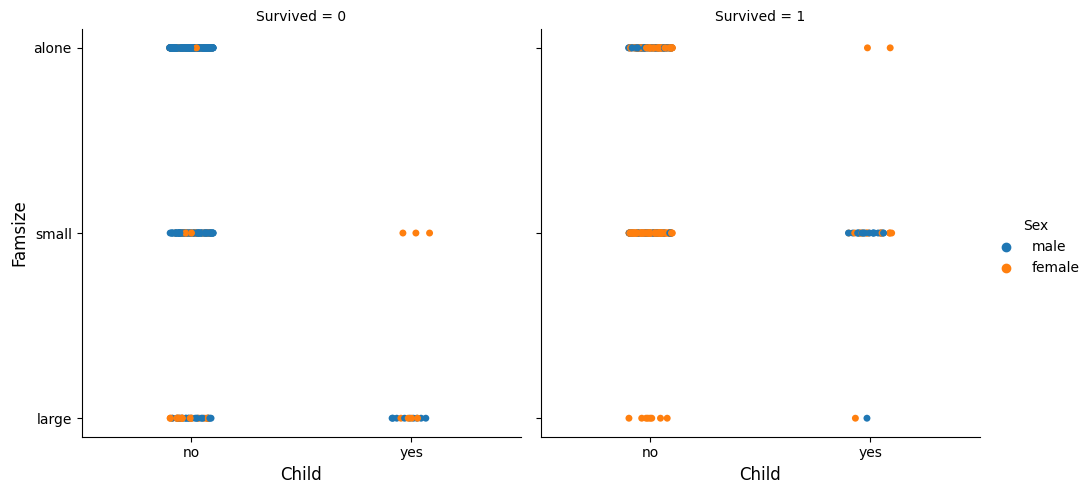

In [249]:
# TWO-DIMENSIONAL DISTRIBUTIONS
g = sns.catplot(data = df_train, x='Child',y='Famsize', hue = 'Sex', col='Survived')
for ax in g.axes.flat:
    ax.set_xlabel('Child', fontsize=12)
    ax.set_ylabel('Famsize', fontsize=12)
    #ax.set_ylim(0,300)

In [250]:
# CREATE BINARY FEATURE FOR CHILDREN IN SMALL FAMILIES
def childsmall(child, fam):
    if (child=='yes') & (fam == 'small'):
        return 'yes'
    else:
        return 'no'
df_train['Childsmall'] = df_train.apply(lambda x: childsmall(x['Child'], x['Famsize']), axis=1)
df_test['Childsmall'] = df_test.apply(lambda x: childsmall(x['Child'], x['Famsize']), axis=1)
# APPEND FEATURE
select_features.append('Childsmall')
# CREATE BINARY FEATURE FOR NON-CHILDREN FEMALES
def fgrown(child, sex):
    if (child=='no') & (sex == 'female'):
        return 'yes'
    else:
        return 'no'
df_train['Fem_grown'] = df_train.apply(lambda x: fgrown(x['Child'], x['Sex']), axis=1)
df_test['Fem_grown'] = df_test.apply(lambda x: fgrown(x['Child'], x['Sex']), axis=1)
# APPEND FEATURE
select_features.append('Fem_grown')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


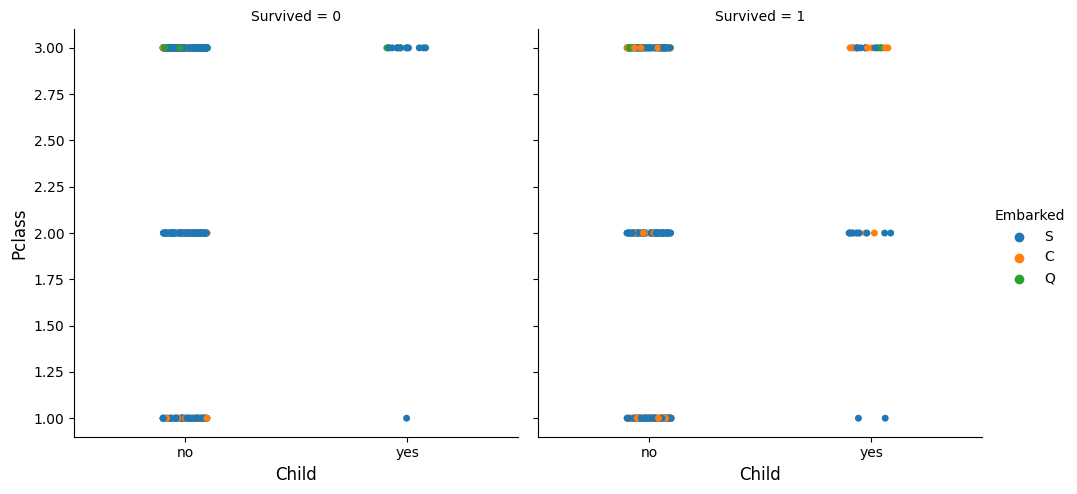

In [251]:
# TWO-DIMENSIONAL DISTRIBUTIONS
g = sns.catplot(data = df_train, x='Child',y='Pclass', hue = 'Embarked', col='Survived')
for ax in g.axes.flat:
    ax.set_xlabel('Child', fontsize=12)
    ax.set_ylabel('Pclass', fontsize=12)
    #ax.set_ylim(0,300)

In [252]:
# CREATE BINARY FEATURE FOR UPPER CLASS CHILDREN
def childup(child, pclass):
    if (child=='yes') & (pclass != 3):
        return 'yes'
    else:
        return 'no'
df_train['Childupper'] = df_train.apply(lambda x: childup(x['Child'], x['Pclass']), axis=1)
df_test['Childupper'] = df_test.apply(lambda x: childup(x['Child'], x['Pclass']), axis=1)
# APPEND FEATURE
select_features.append('Childupper')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


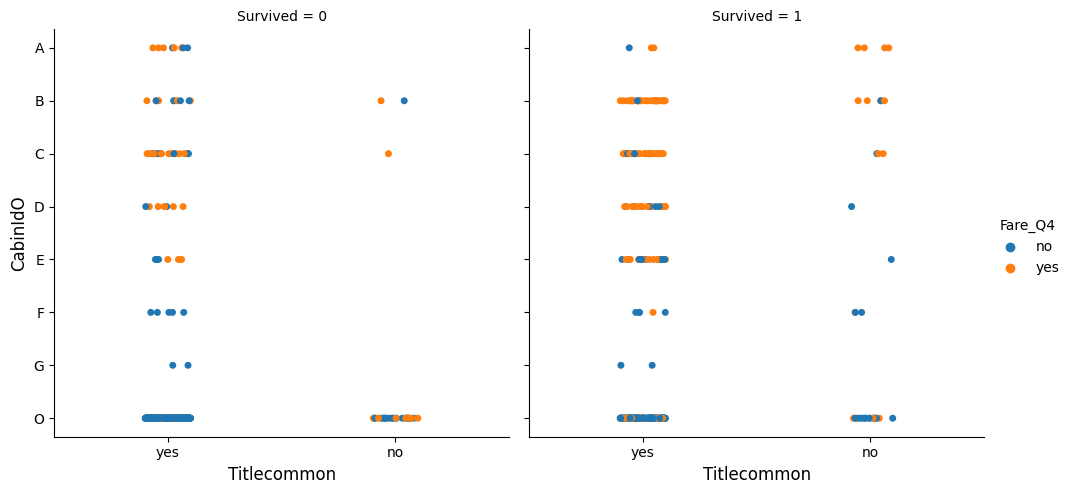

In [253]:
# TWO-DIMENSIONAL DISTRIBUTIONS
g = sns.catplot(data = df_train, x='Titlecommon',y='CabinIdO', hue = 'Fare_Q4', col='Survived')
for ax in g.axes.flat:
    ax.set_xlabel('Titlecommon', fontsize=12)
    ax.set_ylabel('CabinIdO', fontsize=12)
    #ax.set_ylim(0,300)

In [254]:
# CREATE BINARY FEATURE FOR TITLE UNCOMMON AND CABIN NOT G,O
def uncoGO(title, cabin):
    if (title=='no') & (cabin not in ['G', 'O']):
        return 'yes'
    else:
        return 'no'
df_train['UncomAtoF'] = df_train.apply(lambda x: uncoGO(x['Titlecommon'], x['CabinIdO']), axis=1)
df_test['UncomAtoF'] = df_test.apply(lambda x: uncoGO(x['Titlecommon'], x['CabinIdO']), axis=1)
# APPEND FEATURE
select_features.append('UncomAtoF')

# Modeling #

<div class="alert alert-block alert-info">
<b>Modeling strategy:</b>
    
* We will calibrate a series of models, to be used collectively for the final prediction;
</div>

## Set-up variables, convert and scale data ##

In [255]:
print(select_features)

['Sex', 'Pclass', 'Famsize', 'Family_yn', 'Titlecommon', 'Fare_Q4', 'Port_SH', 'CabinIdO', 'AgeRS', 'Child', 'Fem_first', 'Manalone', 'Common_upper', 'Cher_rich', 'Childsmall', 'Fem_grown', 'Childupper', 'UncomAtoF']


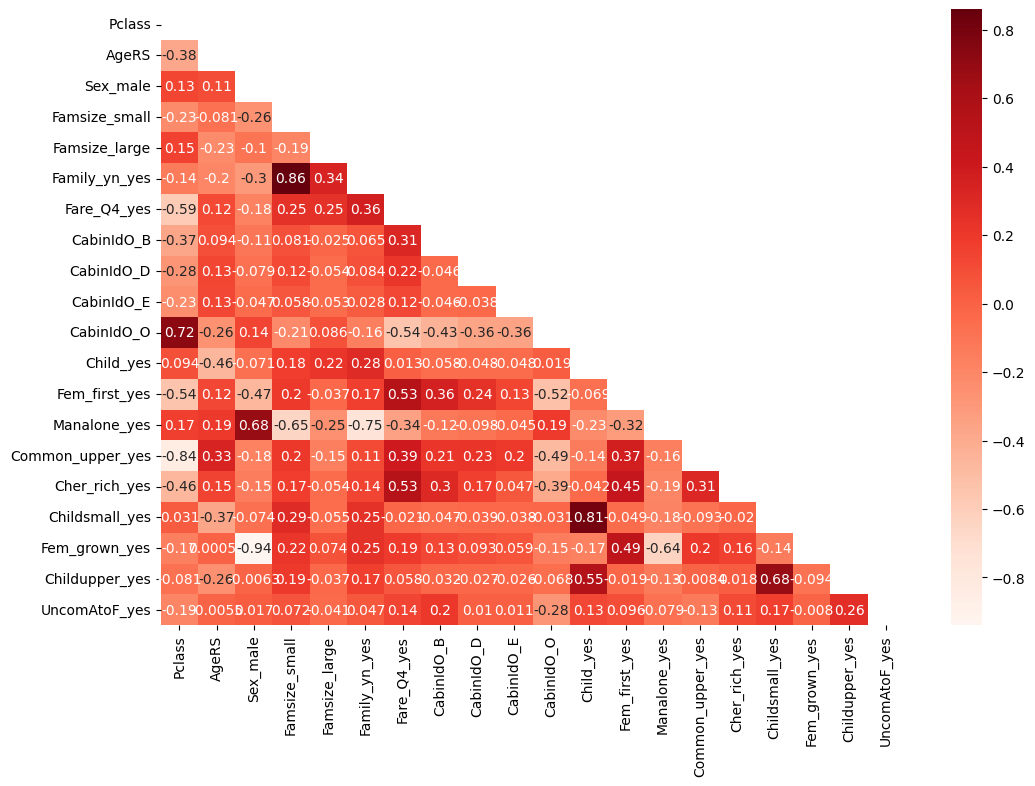

In [267]:
# CREATE DATAFRAMES WITH SELECTED FEATURES
df_train_select=df_train[select_features].copy()
df_test_select=df_test[select_features].copy()
# SELECT FEATURES FROM EDA
#df_train_select = df_train_select.drop(['Sex', 'Pclass', 'Famsize', 'Family_yn', 'Titlecommon', 'Fare_Q4', 'Port_SH', 'CabinIdO', 'AgeRS', 'Child'],axis=1)
#df_test_select = df_test_select.drop(['Sex', 'Pclass', 'Famsize', 'Family_yn', 'Titlecommon', 'Fare_Q4', 'Port_SH', 'CabinIdO', 'AgeRS', 'Child'],axis=1)
# CONVERT CATEGORICAL DATA FOR LOGISTIC REGRESSION CLASSIFIER WITH ONE-HOT ENCODING
# DEFINE PREDICTOR AND OUTCOME VARIABLES
Xdum = pd.get_dummies(df_train_select, drop_first=True)
Xdum_test = pd.get_dummies(df_test_select, drop_first=True)
y = df_train['Survived']

# SELECT TOP 20 FEATURES BASED ON CHI^2 TEST
feat_index = SelectKBest(chi2, k=20).fit(Xdum,y).get_support(indices=True)
Xncd = Xdum.iloc[:,feat_index]
Xncd_test = Xdum_test.iloc[:,feat_index]

# PLOT PEARSON CORRELATION BETWEEN FEATURES
corr = Xncd.corr()
uppertri = np.triu(corr)
fig = plt.figure(figsize=(12,8))
ax1=sns.heatmap(corr, annot=True, cmap='Reds', mask=uppertri)
fig.show()

In [268]:
# GET ROW AND COLUMN NUMBERS FOR LARGE PEARSON CORRELATION (BEYOND +/-0.75)
row,col =  np.nonzero((abs(np.tril(corr))>0.75))
# REMOVE REPEATED ENTRIES, E.G. 1,1 AND 2,2
lrow = [int(i) if i!=j else '' for i,j in zip(row,col)]
# REMOVE COLUMNS FROM Xncd
colname = []
for i,j in enumerate(corr.columns):
    if i in lrow:
        colname.append(j)
Xncd = Xncd.drop(colname, axis=1)
Xncd_test = Xncd_test.drop(colname, axis=1)        

In [269]:
# SPLIT DATA INTO TRAINING AND TRIAL
X_train, X_trial, y_train, y_trial = train_test_split(Xncd, y, test_size=0.25, stratify=y, random_state=0)

In [270]:
# FUNCTION TO RUN AND PLOT RESULTS OF MODEL_PREDICT
def model_preds(model_name, model_type, data_trial=X_trial, data_test=Xncd_test):
    """
    Given a model_name (e.g. model_lg, model_rf, etc) and type (logreg, tree, vector, nb), 
    it will return the model predictions (e.g. preds_lg, preds_lg_test) from the 
    trial and test data (X_trial, and Xncd_test as defaults), a classification report,
    a confusion matrix, and a feature importance/coefficients/excess odds plot for the model.
    """
    # CHECK FOR CORRECT MODEL_TYPE
    if model_type not in ['logreg', 'tree', 'vector', 'nb']:
        print('ERROR: model_type must be set as either tree, logreg, vector or nb.')
        return
    # MAKE PREDICTIONS ON TRIAL AND TEST DATA
    preds = model_name.predict(data_trial)
    preds_test = model_name.predict(data_test)    
    # CLASSIFICATION REPORT
    labels = ['Predicted not to survive', 'Predicted to survive']
    clfrep = classification_report(y_trial, preds, target_names=labels)
    print(clfrep)
    # PLOT CONFUSION MATRIX
    fig_cm = plt.figure(figsize=(2,2))
    cm = confusion_matrix(y_trial, preds, labels = model_name.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model_name.classes_)
    disp.plot(values_format='')
    fig_cm.show()
    # PLOT FEATURE IMPORTANCE, ODDS, COEFFICIENTS
    if model_type == 'tree':
        # FEATURE IMPORTANCE TREE-BASED MODELS
        fig_fi = plt.figure(figsize=(12,3))
        importance = pd.DataFrame()
        importance['Feature'] = data_trial.columns
        importance['Importance'] = model_name.named_steps['model_tree'].feature_importances_
        importance = importance.sort_values(by='Importance', ascending=False)
        ax = sns.barplot(data=importance, x='Feature', y='Importance')
        ax.set_xlabel('Feature', fontsize=16)
        ax.set_ylabel('Feature Importance', fontsize=16)
        plt.xticks(rotation = 45)
        fig_fi.show()
    elif model_type == 'logreg':
        # ODDS FROM LOGISTIC REGRESSION
        fig_odd = plt.figure(figsize = (12,3))
        odds = pd.DataFrame()
        odds['Feature'] = data_trial.columns
        odds['Odds'] = (np.exp(model_name.named_steps['model_lg'].coef_.flatten()))
        odds = odds.sort_values(by = 'Odds', ascending=False, key=abs)
        ax=sns.barplot(data=odds, x='Feature', y='Odds')
        ax.set_xlabel('Feature', fontsize=16)
        ax.set_ylabel('Odds (Survival)', fontsize=16)
        plt.xticks(rotation = 45)        
        fig_odd.show()
    elif model_type == 'vector':
        # VECTOR MAGNITUDES
        fig_vec = plt.figure(figsize = (12,3))
        mags = pd.DataFrame()
        mags['Feature'] = data_trial.columns
        mags['Components'] = np.exp(model_name.named_steps['model_svc'].coef_.flatten())
        mags = mags.sort_values(by = 'Components', ascending=False)
        ax=sns.barplot(data = mags, x='Feature', y='Components')
        ax.set_xlabel('Feature', fontsize=16)
        ax.set_ylabel('Vector Components', fontsize=16)
        plt.xticks(rotation = 45)
        fig_vec.show()
    # RETURN PREDICTIONS
    return preds, preds_test

## Fit model: Logistic Regression ##

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV parameters:  {'model_lg__Cs': 50, 'svd__n_components': 4}
                          precision    recall  f1-score   support

Predicted not to survive       0.77      0.88      0.82       137
    Predicted to survive       0.75      0.58      0.65        86

                accuracy                           0.76       223
               macro avg       0.76      0.73      0.74       223
            weighted avg       0.76      0.76      0.76       223



ValueError: Length of values (4) does not match length of index (15)

<Figure size 200x200 with 0 Axes>

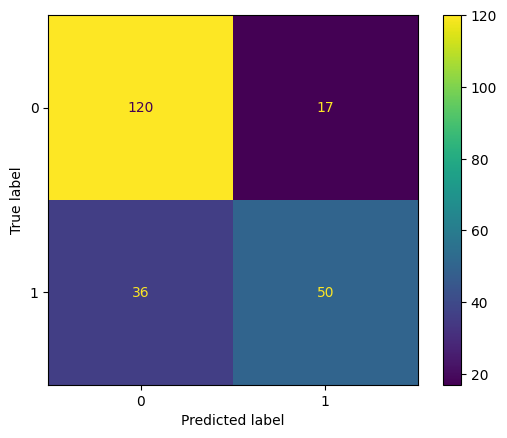

<Figure size 1200x300 with 0 Axes>

In [271]:
%%time
# SETUP MODEL, CROSS-VALIDATION
# PIPELINE FOR CV - THIS IS SCALING THE DATASET FOR EVERY CV FOLD, 
# EVEN THE ONES USING THE SAME DATA FOR TRAINING/TESTING, WHICH IS VEEERY INNEFICIENT...
pl_lg = Pipeline([('scale', StandardScaler()),
                  ('svd', TruncatedSVD(random_state=0)),
                ('model_lg', LogisticRegressionCV(max_iter=1000, tol=0.0001, random_state=0))])
# CV PARAMETERS
par_grid_lg = {'svd__n_components' : [2,3,4],
               'model_lg__Cs' : [50, 100, 200, 250]}
#CROSS-VALIDATION
# FIT MODEL
model_grid_lg = GridSearchCV(pl_lg, param_grid=par_grid_lg, cv=5, refit='f1', n_jobs = -1, verbose = 1)
model_grid_lg.fit(X_train, y_train)
# BEST PREDICTOR
best_lg = model_grid_lg.best_estimator_
print('Best CV parameters: ', model_grid_lg.best_params_)
# GET PREDICTIONS
preds_lg, preds_test_lg = model_preds(best_lg, 'logreg')

## Fit model: Random Forest ##

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best CV parameters:  {'model_tree__max_depth': 12, 'model_tree__max_features': 0.5, 'model_tree__max_samples': 0.8, 'model_tree__min_samples_leaf': 0.001, 'model_tree__min_samples_split': 0.001, 'model_tree__n_estimators': 150}
                          precision    recall  f1-score   support

Predicted not to survive       0.82      0.87      0.84       137
    Predicted to survive       0.77      0.70      0.73        86

                accuracy                           0.80       223
               macro avg       0.79      0.78      0.79       223
            weighted avg       0.80      0.80      0.80       223

CPU times: user 17.3 s, sys: 1.67 s, total: 19 s
Wall time: 12min 21s


<Figure size 200x200 with 0 Axes>

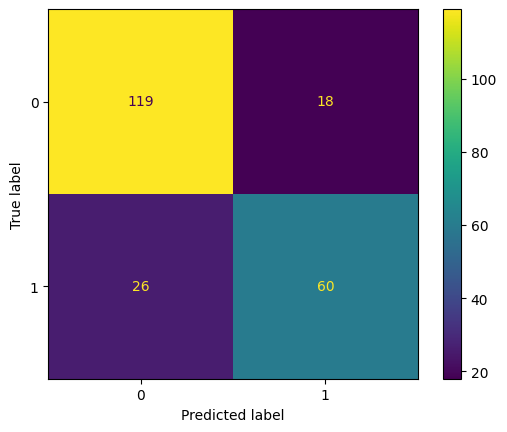

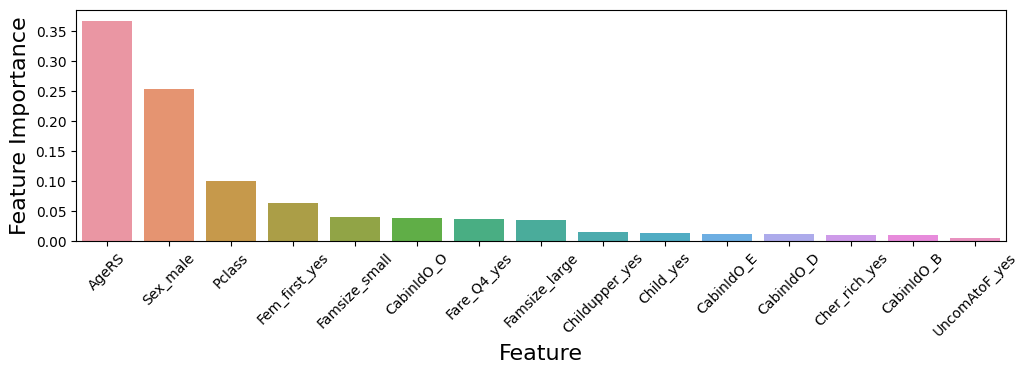

In [272]:
%%time
# SETUP MODEL, CROSS-VALIDATION
# PIPELINE FOR CV - THIS IS SCALING THE DATASET FOR EVERY CV FOLD, 
# EVEN THE ONES USING THE SAME DATA FOR TRAINING/TESTING, WHICH IS VEEERY INNEFICIENT...
# ALSO, SCALING ISN'T NECESSARY FOR TREES, BUT WE'RE BUILDING AN ENSEMBLE MODEL AT THE END,
# SO ALL THE DATA SHOULD BE EITHER SCALED OR NOT
pl_rf = Pipeline([('scale', StandardScaler()),
                ('model_tree', RandomForestClassifier(criterion='entropy', random_state=0))])
# CV PARAMETERS
par_grid_rf = {'model_tree__max_depth' : [10,12,15], 
             'model_tree__max_features' : [0.5,0.7,0.9], 
             'model_tree__max_samples' : [0.7,0.8,0.9], 
             'model_tree__min_samples_leaf' : [0.001,0.005,0.01], 
             'model_tree__min_samples_split' : [0.001,0.005,0.01], 
             'model_tree__n_estimators' : [150, 200, 250]}
#CROSS-VALIDATION
# FIT MODEL
model_grid_rf = GridSearchCV(pl_rf, param_grid=par_grid_rf, cv=5, refit='f1', n_jobs = -1, verbose = 1)
model_grid_rf.fit(X_train, y_train)
# BEST PREDICTOR
best_rf = model_grid_rf.best_estimator_
print('Best CV parameters: ', model_grid_rf.best_params_)
# GET PREDICTIONS
preds_rf, preds_test_rf = model_preds(best_rf, 'tree')

## Fit model: XGB ##

In [262]:
%%time
# SETUP MODEL, CROSS-VALIDATION
# PIPELINE FOR CV - THIS IS SCALING THE DATASET FOR EVERY CV FOLD, 
# EVEN THE ONES USING THE SAME DATA FOR TRAINING/TESTING, WHICH IS VEEERY INNEFICIENT...
# ALSO, SCALING ISN'T NECESSARY FOR TREES, BUT WE'RE BUILDING AN ENSEMBLE MODEL AT THE END,
# SO ALL THE DATA SHOULD BE EITHER SCALED OR NOT
pl_xgb = Pipeline([('scale', StandardScaler()),
                ('model_tree', XGBClassifier(objective = 'binary:logistic', random_state=0))])
# CV PARAMETERS
par_grid_xgb = {'model_tree__max_depth' : [3, 4, 5],
                'model_tree__n_estimators' : [150, 200, 250],
                'model_tree__learning_rate' : [0.1, 0.2, 0.3],
                'model_tree__colsample_bytree' : [0.7, 0.8, 0.9],
                'model_tree__min_child_weight': [7, 10, 13],
                'model_tree__gamma' : [0.7, 0.8, 0.9],
                'model_tree__subsample' : [0.5, 0.7, 0.9]}
#CROSS-VALIDATION
# FIT MODEL
model_grid_xgb = GridSearchCV(pl_xgb, param_grid=par_grid_xgb, cv=5, refit='f1', n_jobs = -1, verbose = 1)
model_grid_xgb.fit(X_train, y_train)
# BEST PREDICTOR
best_xgb = model_grid_xgb.best_estimator_
print('Best CV parameters: ', model_grid_xgb.best_params_)
# GET PREDICTIONS
preds_xgb, preds_test_xgb = model_preds(best_xgb, 'tree')

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


KeyboardInterrupt: 

## Fit model: (Linear) Support Vector Classifier ##

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best CV parameters:  {'model_svc__C': 0.5, 'model_svc__class_weight': None, 'model_svc__dual': False, 'model_svc__max_iter': 1000, 'model_svc__tol': 0.0001}
                          precision    recall  f1-score   support

Predicted not to survive       0.83      0.85      0.84       137
    Predicted to survive       0.76      0.72      0.74        86

                accuracy                           0.80       223
               macro avg       0.79      0.79      0.79       223
            weighted avg       0.80      0.80      0.80       223

CPU times: user 922 ms, sys: 93 ms, total: 1.02 s
Wall time: 5.48 s


<Figure size 200x200 with 0 Axes>

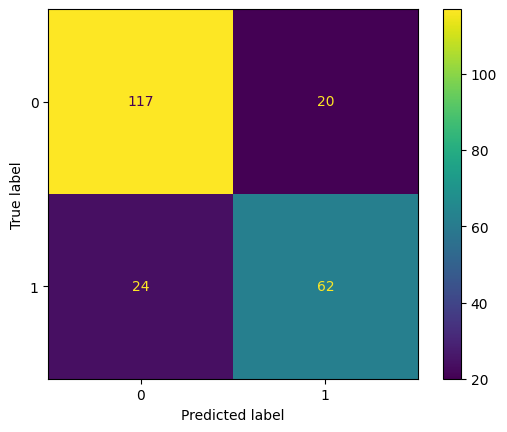

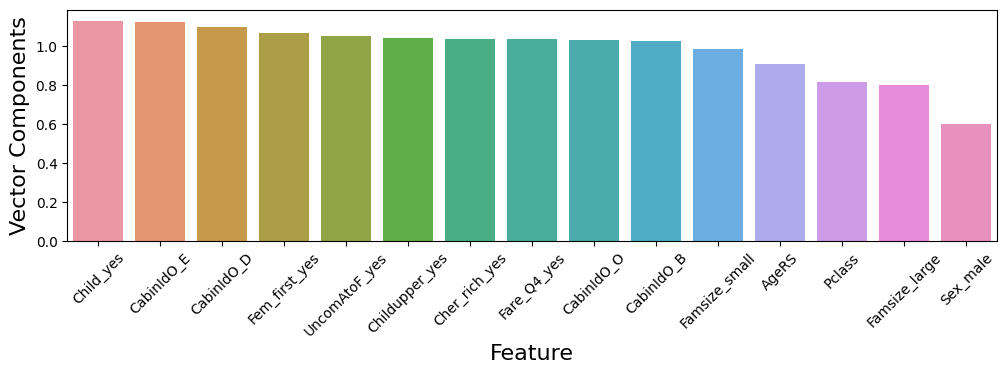

In [263]:
%%time
# SETUP MODEL, CROSS-VALIDATION
# PIPELINE FOR CV - THIS IS SCALING THE DATASET FOR EVERY CV FOLD, 
# EVEN THE ONES USING THE SAME DATA FOR TRAINING/TESTING, WHICH IS VEEERY INNEFICIENT...
pl_svc = Pipeline([('scale', StandardScaler()),
                ('model_svc', LinearSVC(fit_intercept=True, random_state=0))])
# CV PARAMETERS
par_grid_svc = {'model_svc__dual' : [False],
                'model_svc__tol' : [0.0001, 0.000001],
                'model_svc__C' : [0.005, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
                'model_svc__class_weight' : [None, 'balanced'],
                'model_svc__max_iter' : [1000, 10000, 100000, 1000000]}
#CROSS-VALIDATION
# FIT MODEL
model_grid_svc = GridSearchCV(pl_svc, param_grid=par_grid_svc, cv=5, refit='f1', n_jobs = -1, verbose = 1)
model_grid_svc.fit(X_train, y_train)
# BEST PREDICTOR
best_svc = model_grid_svc.best_estimator_
print('Best CV parameters: ', model_grid_svc.best_params_)
# GET PREDICTIONS
preds_svc, preds_test_svc = model_preds(best_svc, 'vector')

## Fit model: Bernoulli Naive Bayes Classifier ##

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best CV parameters:  {'alpha': 1.5}
                          precision    recall  f1-score   support

Predicted not to survive       0.79      0.86      0.83       137
    Predicted to survive       0.74      0.64      0.69        86

                accuracy                           0.78       223
               macro avg       0.77      0.75      0.76       223
            weighted avg       0.77      0.78      0.77       223

CPU times: user 190 ms, sys: 7.65 ms, total: 198 ms
Wall time: 377 ms


<Figure size 200x200 with 0 Axes>

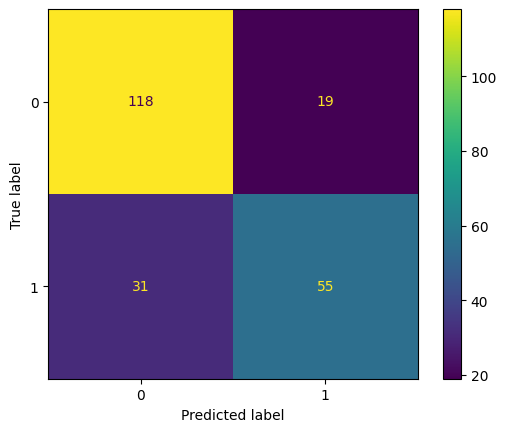

In [264]:
%%time
# SETUP MODEL, CROSS-VALIDATION
# PIPELINE FOR CV - THIS IS SCALING THE DATASET FOR EVERY CV FOLD, 
# EVEN THE ONES USING THE SAME DATA FOR TRAINING/TESTING, WHICH IS VEEERY INNEFICIENT...
model_ber = BernoulliNB()
# CV PARAMETERS
par_grid_ber = {'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}

#CROSS-VALIDATION
# FIT MODEL
model_grid_ber = GridSearchCV(model_ber, param_grid=par_grid_ber, cv=5, refit='f1', n_jobs = -1, verbose = 1)
model_grid_ber.fit(X_train, y_train)
print('Best CV parameters: ', model_grid_ber.best_params_)
# GET PREDICTIONS
preds_ber, preds_test_ber = model_preds(model_grid_ber, 'nb')

## Fit model: Gaussian Naive Bayes Classifier ##

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best CV parameters:  {'alpha': 1.5}
                          precision    recall  f1-score   support

Predicted not to survive       0.73      0.91      0.81       137
    Predicted to survive       0.75      0.47      0.58        86

                accuracy                           0.74       223
               macro avg       0.74      0.69      0.69       223
            weighted avg       0.74      0.74      0.72       223

CPU times: user 192 ms, sys: 8.57 ms, total: 201 ms
Wall time: 381 ms


<Figure size 200x200 with 0 Axes>

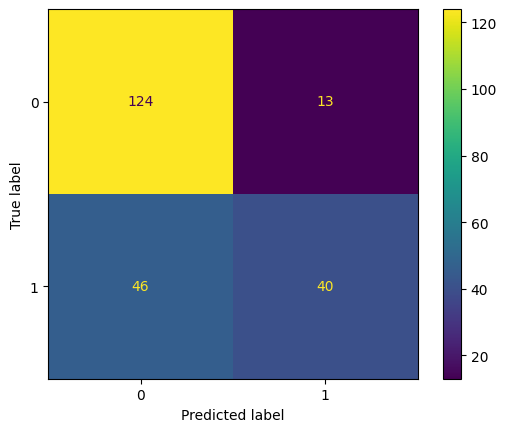

In [265]:
%%time
# SETUP MODEL, CROSS-VALIDATION
# PIPELINE FOR CV - THIS IS SCALING THE DATASET FOR EVERY CV FOLD, 
# EVEN THE ONES USING THE SAME DATA FOR TRAINING/TESTING, WHICH IS VEEERY INNEFICIENT...
model_mn = MultinomialNB()
# CV PARAMETERS
par_grid_mn = {'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]}

#CROSS-VALIDATION
# FIT MODEL
model_grid_mn = GridSearchCV(model_mn, param_grid=par_grid_mn, cv=5, refit='f1', n_jobs = -1, verbose = 1)
model_grid_mn.fit(X_train, y_train)
print('Best CV parameters: ', model_grid_ber.best_params_)
# GET PREDICTIONS
preds_mn, preds_test_mn = model_preds(model_grid_mn, 'nb')

## Stacking Classifier model ##

In [266]:
# BUILD INPUT FOR STACKING CLASSIFIER
x_stack=pd.DataFrame({'Logistic_Regression':preds_lg, 'Random_Forest':preds_rf, 'XGBoosting':preds_xgb, 'Linear-SVC':preds_svc, 'Multinomial_NB':preds_mn, 'Bernoulli_MB':preds_ber})
y_stack = y_trial
x_stack_test=pd.DataFrame({'Logistic_Regression':preds_test_lg, 'Random_Forest':preds_test_rf, 'XGBoosting':preds_test_xgb, 'Linear-SVC':preds_test_svc, 'Multinomial_NB':preds_test_mn, 'Bernoulli_NB':preds_test_ber})
# PLOT PEARSON CORRELATION FOR INPUT
corr = x_stack.corr()
uppertri = np.triu(corr)
fig = plt.figure(figsize=(8,6))
ax1=sns.heatmap(corr, annot=True, cmap='Reds', mask=uppertri)
fig.show()

NameError: name 'preds_rf' is not defined

In [ ]:
# GET RID OF HIGHLY CORRELATED MODELS
#x_stack = x_stack.drop(['Linear-SVC'], axis=1)
#x_stack_test = x_stack_test.drop(['Linear-SVC'], axis=1)

In [ ]:
%%time
# BUILD STACKING CLASSIFIER LOGISTIC REGRESSION MODEL
model_stack = LogisticRegressionCV(Cs = 500, cv = 5, scoring = 'f1', max_iter = 1000, tol=0.0001,refit=True)
#model_stack = XGBClassifier(colsample_bytree = 0.8, gamma=0.7, learning_rate=0.1, max_depth = 4,
                                #min_child_weight = 7, n_estimators = 400, subsample = 0.9, random_state = 0)

# FIT THE MODEL
model_stack.fit(x_stack, y_stack)
# USE MODEL TO MAKE PREDICTIONS ON TRIAL DATASET
preds_stack = model_stack.predict(x_stack_test)

# CREATE OUTPUT FILE FOR SUBMISSION
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': preds_stack})
output.to_csv('submission.csv', index=False)